In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
sns.set_style("whitegrid")
import re
from collections import namedtuple
import statsmodels.api as sm
pd.__version__

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


'0.21.0'

In [2]:
def readData(fileName):
    df = pd.read_excel(fileName, sheet_name='Term Prem Raw', header=[2, 3], usecols='A:R')
    df = (df.sort_index(axis='columns')
          .loc[:, (slice(None), 'PX_LAST')]
          )
    df.columns = df.columns.droplevel(1)
    df.columns.name = 'instrument'
    df.index.name = 'date'
    df = df.sort_index(axis='rows').sort_index(axis='columns')
    
    return df

def readCurveData(fileName):
    df = pd.read_excel(fileName, sheet_name='FW Curve Raw', header=[2, 3],
                       index_col=0, usecols='A:B,D:E,G:H,J:K,M:N,P:Q,S:T')
    df.index.name = tuple(df.columns.names)
    df = df.reset_index()
    df.columns.names = ['instrument', 'field']
    
    groups = []
    for f, g in df.groupby(level=0, axis=1):
        g.columns = g.columns.map(lambda x: 'date' if not re.match('^PX_LAST$', x[1]) else x[0])
        g = g.loc[~pd.isnull(g.date), :]
        g = g.set_index('date')
        groups.append(g)
    
    df = (pd.concat(groups, axis='columns', join='outer')
          .sort_index(axis='rows')
          .sort_index(axis='columns')
         )

    return df

def joinData(df1, df2):
    return df1.join(df2, how='outer').sort_index(axis='columns')

def readTermPremiumData(fileName):
    df = readData(fileName)
    df2 = readCurveData(fileName)
    df = joinData(df, df2)
    return df

In [3]:
RegressionWindow = namedtuple('RegressionWindow', ['date', 'X', 'y'])
def rollingRegressionWindow(data, xnames, yname, window=20, normalize=False):
    data = data[xnames + [yname]]
    data = data.dropna(how='any')
    index = data.index
    X = data[xnames].values
    y = data[yname].values
    if normalize:
        scaler = StandardScaler()
        X = scaler.fit_transform(X)

    for i in range(window, X.shape[0]+1):
        yield RegressionWindow(index[i-1], X[(i - window):i], y[(i - window):i])
        
def rollingRegressionSL(windows, normalize=False, normalizeRegression=False):
    scaler = StandardScaler()
    reg = linear_model.LinearRegression(normalize=normalizeRegression)
    for window in windows:
        if normalize:
            X = scaler.fit_transform(window.X)
        else:
            X = window.X
            
        reg.fit(X, window.y)
        yield window.date, reg
        
def rollingRegressionSM(windows, normalize=False):
    scaler = StandardScaler()
    for window in windows:
        if normalize:
            X = scaler.fit_transform(window.X)
        else:
            X = window.X
        
        X = sm.add_constant(X)
        model = sm.OLS(window.y, X, hasconst=True)
        yield window.date, model.fit()

In [4]:
df = readTermPremiumData('Term Premium BLP.xlsm')
df['5s10sdelta'] = 100*(df['ACMTP10 Index'] - df['ACMTP05 Index'])

In [5]:
windows = rollingRegressionWindow(df, ['5s10sdelta'], '5s10s', window=250, normalize=True)
coeffs = []
intercepts = []
dates = []
for date, r in rollingRegressionSL(windows, normalizeRegression=True):
    dates.append(date)
    coeffs.append(r.coef_[0])
    intercepts.append(r.intercept_.copy())

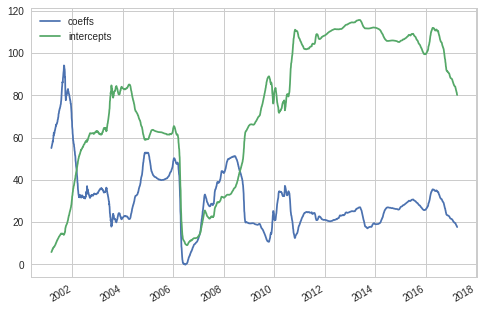

In [6]:
results = pd.DataFrame({'coeffs': coeffs, 'intercepts': intercepts}, index=dates)
results.plot()
plt.show()